In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lectura de datos
ipc_data = pd.read_csv("IPC-2010.csv", parse_dates=[0], infer_datetime_format=True)
# ipc_data.index = pd.DatetimeIndex(ipc_data.Fecha).to_period('M')
# ipc_data = ipc_data.drop(columns="Fecha")
ipc_data

,Fecha,IPC
0,2010-12-01,100.000000
1,2011-01-01,100.770644
2,2011-02-01,101.532971
3,2011-03-01,102.414641
4,2011-04-01,103.167484
...,...,...
111,2020-03-01,141.567519
112,2020-04-01,142.575371
113,2020-05-01,142.846324
114,2020-06-01,144.860005


In [3]:
# Normalización de datos con arreglo de numpy con la serie normalizada
ipc_norm = ipc_data["IPC"].values / 100
ipc_norm

array([1.        , 1.00770644, 1.01532971, 1.02414641, 1.03167484,
       1.03680207, 1.04232501, 1.05221484, 1.05853474, 1.05784663,
       1.05737044, 1.05974485, 1.06200031, 1.06296763, 1.06833599,
       1.07175016, 1.07578193, 1.07721758, 1.07851022, 1.08232365,
       1.08721229, 1.09246228, 1.0927829 , 1.09272105, 1.09857214,
       1.10394852, 1.11299603, 1.11833004, 1.12022356, 1.12321051,
       1.13019697, 1.13359222, 1.13524494, 1.13847015, 1.13815968,
       1.14329338, 1.1467586 , 1.14975126, 1.15200791, 1.15463646,
       1.15679582, 1.15943513, 1.16564127, 1.17226312, 1.17716068,
       1.17778107, 1.17963389, 1.18195015, 1.18062257, 1.1763488 ,
       1.18006454, 1.18264671, 1.18657048, 1.18900067, 1.19339835,
       1.19951535, 1.20034989, 1.19986055, 1.20594453, 1.21155946,
       1.21683169, 1.22791026, 1.23046981, 1.23304811, 1.2351148 ,
       1.24081603, 1.24625816, 1.25487171, 1.2571856 , 1.25461612,
       1.26330221, 1.26824217, 1.26830248, 1.27485165, 1.27922

In [4]:
# Número de observaciones
len(ipc_norm)

116

In [5]:
# Convertir la serie a un conjunto X, Y de entrenamiento 
X_data = []
Y_data = []
T = len(ipc_norm)
for i in range(12, T):
    X_data.append(ipc_norm[i-12:i])
    Y_data.append(ipc_norm[i])

X_data = np.array(X_data)
Y_data = np.array(Y_data)


In [6]:
print('Shape datos X de entrenamiento: ', X_data.shape)
print('Shape datos Y de entrenamiento: ', Y_data.shape)

Shape datos X de entrenamiento:  (104, 12)
Shape datos Y de entrenamiento:  (104,)


## Definición de la red neuronal de pronóstico

In [7]:
# Importamos el módulo keras del framework TensorFlow
import tensorflow.keras as keras
import tensorflow as tf
keras.__version__

'2.2.4-tf'

In [8]:
# Importamos el modelo Sequential y las capas Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
# Dense?

In [10]:
np.random.seed(1618)
tf.random.set_seed(314)

In [11]:
# Definición del model AR de redes neuronales 
arnn_model = Sequential([
    Dense(8, input_shape=(12,), activation='relu'), 
    Dense(1, activation='relu')
])

# Este método muestra un resumen de las capas y los parámetros entrenables del modelo
arnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compilación del modelo
# - Definimos la función de pérdida, computada entre la salida del modelo y los valores Y provistos
# - Seleccionamos un algoritmo de optimización
arnn_model.compile(optimizer='adam', loss='mse')
# arnn_model.optimizer.learning_rate.assign(0.001)

In [13]:
# Llevamos a cabo el entrenamiento
history = arnn_model.fit(x=X_data, y=Y_data, batch_size=32, epochs=100, verbose=0, validation_split=0.15)
print('Final train loss: %0.5f' % history.history["loss"][-1])
print('Final val loss: %0.5f' % history.history["val_loss"][-1])

Final train loss: 0.00008
Final val loss: 0.00032


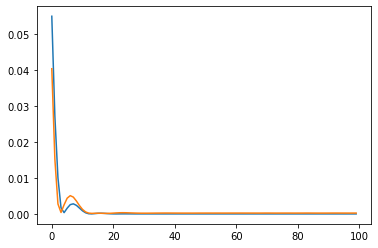

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

In [15]:
# Obtenemos valores de pronóstico intramuestra del modelo
Y_hat = arnn_model.predict(X_data)
Y_hat.shape

(104, 1)

In [16]:
ipc_hat = ipc_data.loc[12:]
ipc_hat["IPC_norm_hat"] = Y_hat*100
ipc_hat

,Fecha,IPC,IPC_norm_hat
12,2011-12-01,106.200031,105.548630
13,2012-01-01,106.296763,106.465530
14,2012-02-01,106.833599,107.207169
15,2012-03-01,107.175016,107.736847
16,2012-04-01,107.578193,107.959496
...,...,...,...
111,2020-03-01,141.567519,143.311615
112,2020-04-01,142.575371,143.371445
113,2020-05-01,142.846324,144.276062
114,2020-06-01,144.860005,145.427872


In [17]:
# Conjunto de datos observado y ajustado en la muestra
# ipc_hat = ipc_data.loc['2011-12':]
# ipc_hat["IPC_norm_hat"] = Y_hat
# ipc_hat

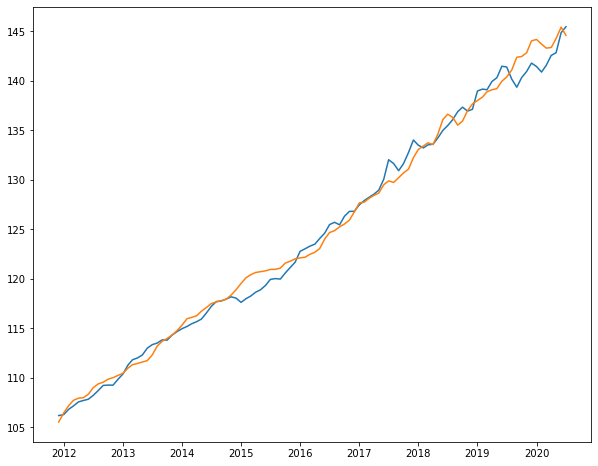

In [18]:
# Gráfica de los valores ajustados y observados dentro de la muestra
plt.figure(figsize=(10,8))
plt.plot(ipc_hat["Fecha"], ipc_hat.iloc[:, 1:])

## Generando pronósticos de inflación

In [19]:
# Pronóstico a un horizonte de 12 meses
H = 12
Y_forecast = []
X_forecast_window = ipc_norm[-12:].reshape(1, -1)

for h in range(1, H+1):
    forecast = arnn_model.predict(X_forecast_window)
    Y_forecast.append(forecast.flatten()[0])
    X_forecast_window = np.hstack((X_forecast_window[:, 1:], forecast))

In [20]:
Y_forecast

[1.439307,
 1.4400872,
 1.4453804,
 1.4616333,
 1.4737703,
 1.4679062,
 1.4686949,
 1.4661723,
 1.4683231,
 1.4870896,
 1.4986125,
 1.5005528]

In [21]:
# Creamos rango de fechas
forecast_dates = pd.period_range(start=pd.Period('2020-08', 'M'), periods=H, freq='M')

# Creamos dataframe de pronóstico
ipc_forecast_df = pd.DataFrame({"Fecha": forecast_dates.to_timestamp(), "IPC" : np.array(Y_forecast)*100})
ipc_forecast_df

,Fecha,IPC
0,2020-08-01,143.930695
1,2020-09-01,144.008713
2,2020-10-01,144.538040
3,2020-11-01,146.163330
4,2020-12-01,147.377029
5,2021-01-01,146.790619
6,2021-02-01,146.869492
7,2021-03-01,146.617233
8,2021-04-01,146.832306
9,2021-05-01,148.708969


In [22]:
# Creamos un DataFrame final con observaciones y pronósticos fuera de muestra
ipc_final = pd.concat([ipc_data, ipc_forecast_df])
ipc_final.tail(25)

,Fecha,IPC
103,2019-07-01,141.403722
104,2019-08-01,140.175061
105,2019-09-01,139.360786
106,2019-10-01,140.329092
107,2019-11-01,140.952375
108,2019-12-01,141.795456
109,2020-01-01,141.455175
110,2020-02-01,140.890747
111,2020-03-01,141.567519
112,2020-04-01,142.575371


In [23]:
# Ahora vamos a computar el pronóstico de inflación, para esto utilizamos la columna de IPC
# ipc_final["IPC"][12:]
# ipc_final["IPC"][:-12]

In [39]:
# Obtener la variación interanual
infl_total = 100 * (ipc_final["IPC"][12:].values / ipc_final["IPC"][:-12].values - 1)
infl_total

array([6.20003089, 5.48385849, 5.22059695, 4.64813907, 4.27528961,
       3.89809258, 3.47158623, 2.86146943, 2.70917449, 3.27227454,
       3.34910714, 3.11171111, 3.44367441, 3.85532796, 4.18033728,
       4.34615084, 4.13110001, 4.26960504, 4.79242117, 4.73689882,
       4.41796384, 4.21139219, 4.15240532, 4.62810959, 4.38628098,
       4.14899246, 3.50512266, 3.24648544, 3.26472866, 3.22509572,
       3.13611667, 3.41135879, 3.6922205 , 3.45296006, 3.64397127,
       3.381177  , 2.95301658, 2.31332951, 2.43545477, 2.42589355,
       2.57389062, 2.54999537, 2.38127163, 2.32475367, 1.96992699,
       1.8746679 , 2.2304069 , 2.50512282, 3.06695122, 4.38317818,
       4.27139942, 4.2617462 , 4.09114556, 4.35789116, 4.42935119,
       4.61489362, 4.73492897, 4.56349441, 4.75624532, 4.67849193,
       4.22990184, 3.82286839, 3.96220047, 3.99422446, 4.08713207,
       3.93243554, 4.37108635, 5.22233251, 4.72074088, 4.35995939,
       4.20574325, 4.68911203, 5.67714868, 4.71929374, 4.14946

In [40]:
# Agregamos columna de inflación al DataFrame de pronóstico final
ipc_final["Inflacion"] = np.nan
ipc_final["Inflacion"][12:] = infl_total
ipc_final.tail(20)

,Fecha,IPC,Inflacion
108,2019-12-01,141.795456,3.399301
109,2020-01-01,141.455175,1.783453
110,2020-02-01,140.890747,1.235799
111,2020-03-01,141.567519,1.769625
112,2020-04-01,142.575371,1.878689
113,2020-05-01,142.846324,1.802701
114,2020-06-01,144.860005,2.388203
115,2020-07-01,145.474146,2.878583
0,2020-08-01,143.930695,2.679245
1,2020-09-01,144.008713,3.335176


(0.0, 7.0)

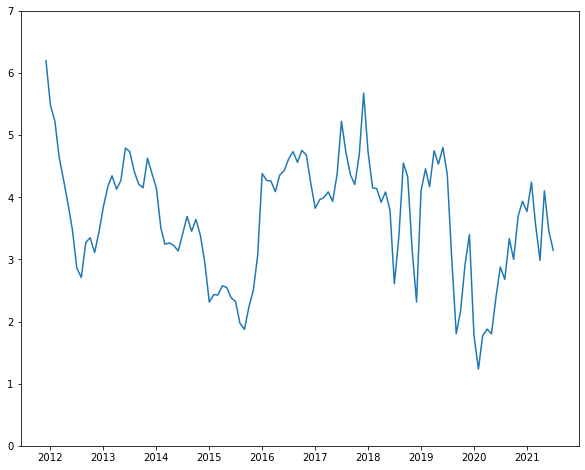

In [41]:
# Graficamos los valores de inflación 
plt.figure(figsize=(10,8))
plt.plot(ipc_final["Fecha"], ipc_final["Inflacion"])
plt.ylim((0, 7))

## Guardando el modelo y sus pesos

In [42]:
# Devuelve una representación en formato JSON del modelo Sequential
arnn_model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 12], "dtype": "float32", "units": 8, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}]}, "keras_version": "2.2.4-tf", "backend": "tensor

In [28]:
# Guardar el modelo en formato JSON
with open("arnn_model.json", "w") as json_file:
    json_file.write(arnn_model.to_json())

# Guardar los pesos de la red neuronal en HDF5
arnn_model.save_weights("arnn_model_weights.h5")
print("Archivos de modelo ARNN generados")

Archivos de modelo ARNN generados


## Modelo con redes neuronales recurrentes de tipo GRU

In [43]:
# Obtenemos valores de inflación para utilizar como secuencia
seq_inflacion = ipc_final["Inflacion"][12:-12].values

# Convertir la serie a un conjunto X, Y de entrenamiento 
X_data = []
Y_data = []
T = len(seq_inflacion)
for i in range(12, T):
    X_data.append(seq_inflacion[i-12:i])
    Y_data.append(seq_inflacion[i])

X_data = np.array(X_data)
Y_data = np.array(Y_data)

print('Shape datos X: ', X_data.shape)
print('Shape datos Y: ', Y_data.shape)

Shape datos X:  (92, 12)
Shape datos Y:  (92,)


In [44]:
X_data[0]

array([6.20003089, 5.48385849, 5.22059695, 4.64813907, 4.27528961,
       3.89809258, 3.47158623, 2.86146943, 2.70917449, 3.27227454,
       3.34910714, 3.11171111])

In [45]:
Y_data[0]

3.443674406234609

In [46]:
np.random.seed(1618)
tf.random.set_seed(314)

In [47]:
# Definición del modelo para secuencia de valores de inflación 
gru_model = Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[12, 1]),
    keras.layers.GRU(32, return_sequences=False),
    keras.layers.Dense(1, activation='relu')
])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 32)            3360      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [32]:
# gru_model(X_data[:, :, None].astype(np.float32)).shape

In [49]:
tuned_adam = keras.optimizers.Adam(learning_rate=0.001)
gru_model.compile(optimizer='adam', loss='mse')

In [52]:
history = gru_model.fit(x=X_data[:, :, None].astype(np.float32), y=Y_data, epochs=200, \
     validation_split=0.1, verbose=1)
print('Final train loss: %0.5f' % history.history["loss"][-1])
print('Final val loss: %0.5f' % history.history["val_loss"][-1])

 0.2044 - val_loss: 0.3558
Epoch 11/200
82/82 [==============================] - 0s 414us/sample - loss: 0.2040 - val_loss: 0.3566
Epoch 12/200
82/82 [==============================] - 0s 341us/sample - loss: 0.2039 - val_loss: 0.3545
Epoch 13/200
82/82 [==============================] - 0s 353us/sample - loss: 0.2036 - val_loss: 0.3509
Epoch 14/200
82/82 [==============================] - 0s 425us/sample - loss: 0.2037 - val_loss: 0.3483
Epoch 15/200
82/82 [==============================] - 0s 353us/sample - loss: 0.2033 - val_loss: 0.3517
Epoch 16/200
82/82 [==============================] - 0s 389us/sample - loss: 0.2048 - val_loss: 0.3547
Epoch 17/200
82/82 [==============================] - 0s 341us/sample - loss: 0.2044 - val_loss: 0.3638
Epoch 18/200
82/82 [==============================] - 0s 377us/sample - loss: 0.2053 - val_loss: 0.3520
Epoch 19/200
82/82 [==============================] - 0s 316us/sample - loss: 0.2034 - val_loss: 0.3432
Epoch 20/200
82/82 [=================

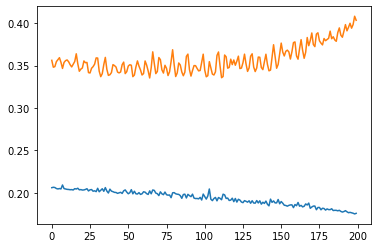

In [53]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

In [54]:
# Pronóstico a un horizonte de 12 meses
H = 12
Y_forecast = []
X_forecast_window = seq_inflacion[-12:].reshape(1, -1)

for h in range(1, H+1):
    forecast = gru_model.predict(X_forecast_window[:, :, None])
    Y_forecast.append(forecast.flatten()[0])
    X_forecast_window = np.hstack((X_forecast_window[:, 1:], forecast))

# Creamos rango de fechas
forecast_dates = pd.period_range(start=pd.Period('2020-08', 'M'), periods=H, freq='M')

# Creamos dataframe de pronóstico
infl_forecast_df = pd.DataFrame({"Fecha": forecast_dates.to_timestamp(), "Inflacion" : np.array(Y_forecast)})
infl_forecast_df

,Fecha,Inflacion
0,2020-08-01,3.083442
1,2020-09-01,3.320913
2,2020-10-01,3.650079
3,2020-11-01,3.948176
4,2020-12-01,4.124020
5,2021-01-01,4.210000
6,2021-02-01,4.260246
7,2021-03-01,4.294841
8,2021-04-01,4.304419
9,2021-05-01,4.285465


In [55]:
# DataFrame de pronóstico de inflación
infl_final = pd.concat([ipc_final.iloc[12:-12, [0, 2]], infl_forecast_df])
infl_final.tail(20)

,Fecha,Inflacion
108,2019-12-01,3.399301
109,2020-01-01,1.783453
110,2020-02-01,1.235799
111,2020-03-01,1.769625
112,2020-04-01,1.878689
113,2020-05-01,1.802701
114,2020-06-01,2.388203
115,2020-07-01,2.878583
0,2020-08-01,3.083442
1,2020-09-01,3.320913


(0.0, 7.0)

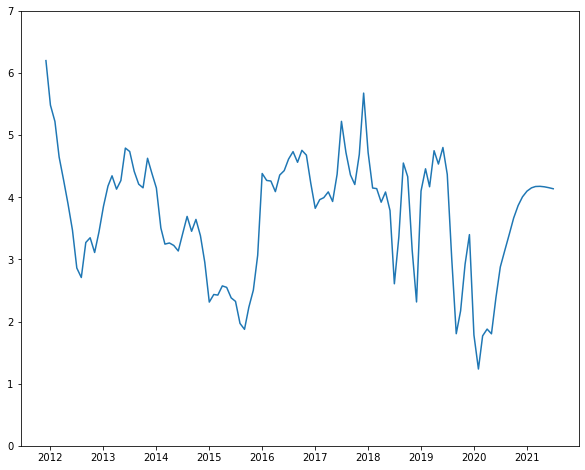

In [38]:
# Graficamos los valores de inflación 
plt.figure(figsize=(10,8))
plt.plot(infl_final["Fecha"], infl_final["Inflacion"])
plt.ylim((0, 7))